In [9]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import scipy
import sklearn
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
def api_caller(date):
    api_url = f'https://www.hongkongairport.com/flightinfo-rest/rest/flights/past?date={date}&lang=en&cargo=false&arrival=false'

    # Make a GET request to the API
    response = requests.get(api_url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Parse the JSON response
        data = response.json()

    # Flatten the data for pandas DataFrame
    flattened_data = []
    for entry in data:
        for flight_info in entry['list']:
            flattened_data.append({
                "date": entry["date"],
                "time": flight_info["time"],
                "flight_no": flight_info["flight"][0]["no"],
                "airline": flight_info["flight"][0]["airline"],
                "status": flight_info["status"],
                "destination": ', '.join(flight_info["destination"]),
                "terminal": flight_info["terminal"],
                "aisle": flight_info["aisle"],
                "gate": flight_info["gate"]
            })

    # Create a DataFrame
    df = pd.DataFrame(flattened_data)
    return df

In [3]:
def raw_data_caller():
    data = []
    for j in range(9,12):
        for i in range(1,31):
            try:
                date = f'2023-{j}-{i}'
                #print(date)
                data.append(api_caller(date))
            except:
                pass
    df = pd.concat(data)
    return df

In [4]:
def data_stall(df):
    df.to_csv('flight_data.csv', index=False)

In [6]:
def data_ret():
    return pd.read_csv('flight_data.csv')

In [3]:
def data_cleaner(df):
    import re
    # Extract time from 'status' column using regex
    time_pattern = re.compile(r'Dep (\d{2}:\d{2})(?: \((\d{2}/\d{2}/\d{4})\))?')
    matches = df['status'].str.extract(time_pattern)
    # Fill NaN values in 'matches[1]' with corresponding values from 'date' column
    matches[1] = matches[1].fillna(df['date'])
    matches[1] = pd.to_datetime(matches[1], errors='coerce', format='%Y-%m-%d') 
    matches[1] = matches[1].fillna((pd.to_datetime(df['date'], errors='coerce')+ pd.DateOffset(days=1)).dt.strftime('%Y-%m-%d'))

    # Combine 'status_time' and 'date' based on matches[1] presence
    df['status_time'] = pd.to_datetime(matches[1].dt.strftime('%Y-%m-%d') + ' ' + matches[0])

    # Convert 'status_time' and 'time' columns to datetime objects
    df['cal_time'] = pd.to_datetime(df['date'] + ' ' + df['time'])

    # Calculate the time difference in minutes and create a new 'delta' column
    df['delta'] = (df['status_time'] - df['cal_time']).dt.total_seconds() / 60
    df = df[df['status'] != 'Cancelled'].reset_index(drop=True)
    
    # Print the updated DataFrame
    return df

In [4]:
def data_pred_train(df):
    # Separate the DataFrame into two parts based on the timestamp
    specific_timestamp = pd.to_datetime('2023-11-18 00:00:00')
    train = df[df['cal_time'] < specific_timestamp].reset_index(drop=True)
    predict = df[df['cal_time'] >= specific_timestamp].reset_index(drop=True)
    return train, predict


In [7]:
df = data_cleaner(raw_data_caller())

In [ ]:
data_stall(df)

In [10]:
df = data_cleaner(data_ret())
df_demo, predict = data_pred_train(df)
df_demo

,date,time,flight_no,airline,status,destination,terminal,aisle,gate,status_time,cal_time,delta
0,2023-09-01,00:05,CX 315,CPA,Dep 00:48,MAD,T1,A,49.0,2023-09-01 00:48:00,2023-09-01 00:05:00,43.0
1,2023-09-01,00:05,CX 880,CPA,Dep 00:38,LAX,T1,A,41.0,2023-09-01 00:38:00,2023-09-01 00:05:00,33.0
2,2023-09-01,00:20,CX 105,CPA,Dep 00:40,MEL,T1,A,66.0,2023-09-01 00:40:00,2023-09-01 00:20:00,20.0
3,2023-09-01,00:25,ET 645,ETH,Dep 01:13,ADD,T1,D,40.0,2023-09-01 01:13:00,2023-09-01 00:25:00,48.0
4,2023-09-01,00:25,QR 815,QTR,Dep 00:22,DOH,T1,E,5.0,2023-09-01 00:22:00,2023-09-01 00:25:00,-3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
23662,2023-11-17,23:55,CX 101,CPA,Dep 00:00 (18/11/2023),SYD,T1,A,2.0,2023-11-18 00:00:00,2023-11-17 23:55:00,5.0
23663,2023-11-17,23:55,UO 624,HKE,Dep 00:17 (18/11/2023),HND,T1,H,217.0,2023-11-18 00:17:00,2023-11-17 23:55:00,22.0
23664,2023-11-17,22:45,PR 311,PAL,Dep 02:14 (18/11/2023),MNL,T1,F,33.0,2023-11-18 02:14:00,2023-11-17 22:45:00,209.0
23665,2023-11-17,23:55,CX 101,CPA,Dep 00:00 (18/11/2023),SYD,T1,A,2.0,2023-11-18 00:00:00,2023-11-17 23:55:00,5.0


In [36]:
df_demo['delta_01'] = (df_demo['delta'] > 5).astype(int)

In [37]:
specific_timestamp = pd.to_datetime('2023-11-17 00:00:00')
test_indeces = (df_demo['cal_time'] >= specific_timestamp).idxmax()

In [38]:
test_indeces

23317

In [39]:
df_train = df_demo.loc[:,['destination','aisle','gate','flight_no']]
target = df_demo.loc[:,['delta_01']]
df_predictor = pd.get_dummies(df_train, columns=['destination','aisle','gate','flight_no'])

X_train = df_predictor[:test_indeces]
y_train = target[:test_indeces]

X_test = df_predictor[test_indeces:]
y_test = target[test_indeces:]

In [15]:
X_train

,destination_ADD,destination_AKL,destination_AMS,destination_BKI,destination_BKK,"destination_BKK, ADD","destination_BKK, DXB",destination_BLR,destination_BNE,destination_BOM,...,flight_no_VJ 877,flight_no_VJ 967,flight_no_VJ 985,flight_no_VN 593,flight_no_VN 595,flight_no_Z2 1265,flight_no_ZH 8034,flight_no_ZH 9086,flight_no_ZH 9092,flight_no_ZH 9096
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23312,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
23313,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
23314,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
23315,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [40]:
def LSTM_model(X_train, X_test, y_train, y_test):
    

    X_train = X_train.to_numpy().reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.to_numpy().reshape((X_test.shape[0], 1, X_test.shape[1]))

    clf = Sequential()
    clf.add(LSTM(units=120, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    clf.add(Dropout(0.3))  # Dropout for regularization

    # Third LSTM layer with more units and dropout
    clf.add(LSTM(units=100, activation='relu'))
    clf.add(Dropout(0.3))  # Dropout for regularization

    # Dense layer with more units
    clf.add(Dense(units=50, activation='relu'))

    # Output layer
    clf.add(Dense(units=1, activation='sigmoid'))

    # Compile the model
    clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    clf.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_test, y_test))

    # Make predictions on the test set
    y_prob = clf.predict(X_test)

    custom_threshold = 0.5
    y_test_pred = (y_prob > custom_threshold).astype(int)
    y_test_set = pd.DataFrame(y_prob, columns=['Prob'])
    return y_test_set

In [17]:
def logistic_model(X_train, X_test, y_train, y_test):
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)[:, 1]
    test_set = pd.DataFrame(y_prob, columns=['Prob'])
    return test_set

In [41]:
def metric(df, y_test_set, test_indices):
    
    prob_delta = (df.iloc[test_indices:,]).reset_index(drop=True)
    
    prob = pd.concat([y_test_set, prob_delta] , axis=1)
    #prob = prob[prob['airline'] == 'CPA']
    prob = prob.sort_values(by='Prob', ascending=False).reset_index(drop=True)
    
    # Specify the columns for the scatter plot
    column_x = 'Prob'
    column_y = 'delta'
    filtered_df = prob[prob['delta'] <= 200]
    # Plot the scatter plot
    # Plot the scatter plot with regression line
    import seaborn as sns
    sns.regplot(x=column_x, y=column_y, data=filtered_df, scatter_kws={'s': 50}, line_kws={'color': 'red', 'label': 'Regression Line'})

    # Add labels and title
    plt.xlabel(column_x)
    plt.ylabel(column_y)
    plt.title('Scatter Plot with Regression Line (Values <= 200)')
    plt.legend()

    # Show the plot
    plt.show()
    prob_20 = prob[:10]
    print(prob_20[prob_20['delta'] > 15].count()[0]/10)
    print(prob['delta'][:10].mean())
    return prob

In [42]:
y_test_set = LSTM_model(X_train, X_test, y_train, y_test)


Epoch 1/3
729/729 [==============================] - 18s 18ms/step - loss: 0.6208 - accuracy: 0.6533 - val_loss: 0.6078 - val_accuracy: 0.6629
Epoch 2/3
729/729 [==============================] - 14s 19ms/step - loss: 0.5798 - accuracy: 0.6973 - val_loss: 0.6281 - val_accuracy: 0.6629
Epoch 3/3
11/11 [==============================] - 1s 14ms/step


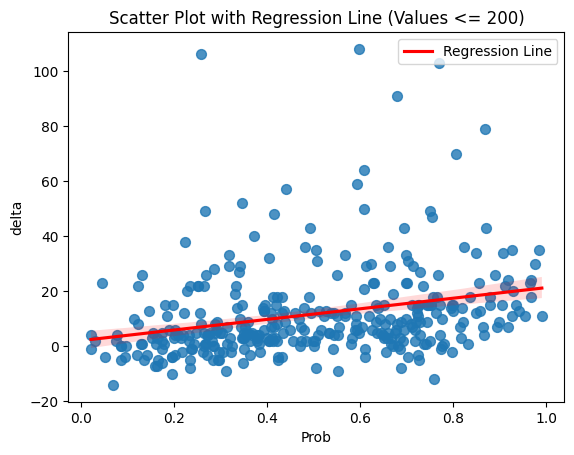

0.6
20.0


,Prob,date,time,flight_no,airline,status,destination,terminal,aisle,gate,status_time,cal_time,delta,delta_01
0,0.990290,2023-11-17,13:00,CX 346,CPA,Dep 13:11,SHA,T1,A,67.0,2023-11-17 13:11:00,2023-11-17 13:00:00,11.0,1
1,0.983860,2023-11-17,12:45,TG 601,THA,Dep 13:20,BKK,T1,H,28.0,2023-11-17 13:20:00,2023-11-17 12:45:00,35.0,1
2,0.974855,2023-11-17,08:20,CX 994,CPA,Dep 08:50,FOC,T1,A,40.0,2023-11-17 08:50:00,2023-11-17 08:20:00,30.0,1
3,0.967733,2023-11-17,12:25,CX 884,CPA,Dep 12:43,LAX,T1,C,9.0,2023-11-17 12:43:00,2023-11-17 12:25:00,18.0,1
4,0.967607,2023-11-17,14:15,GA 863,GIA,Dep 14:39,CGK,T1,J,25.0,2023-11-17 14:39:00,2023-11-17 14:15:00,24.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,0.053139,2023-11-17,15:25,CA 420,CCA,Dep 15:21,CKG,T1,J,7.0,2023-11-17 15:21:00,2023-11-17 15:25:00,-4.0,0
346,0.045015,2023-11-17,20:50,HX 496,CRK,Dep 21:13,CKG,T1,K,217.0,2023-11-17 21:13:00,2023-11-17 20:50:00,23.0,1
347,0.030993,2023-11-17,07:35,UO 820,HKE,Dep 07:37,OKA,T1,H,205.0,2023-11-17 07:37:00,2023-11-17 07:35:00,2.0,0
348,0.022937,2023-11-17,20:00,MU 2570,CES,Dep 19:59,WUH,T1,J,26.0,2023-11-17 19:59:00,2023-11-17 20:00:00,-1.0,0


In [43]:
prob = metric(df_demo, y_test_set,test_indeces)
prob

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


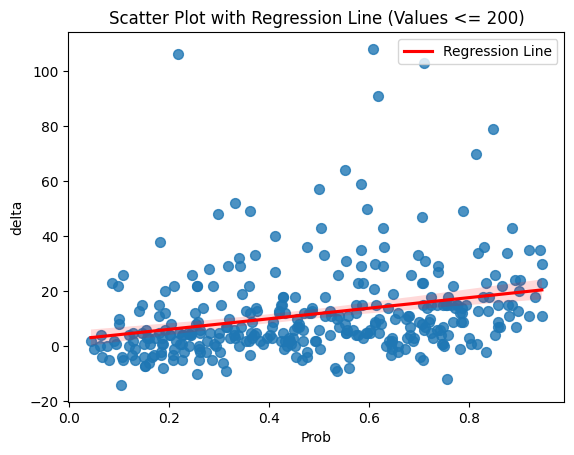

0.7
22.0


,Prob,date,time,flight_no,airline,status,destination,terminal,aisle,gate,status_time,cal_time,delta,delta_01
0,0.945242,2023-11-17,13:00,CX 346,CPA,Dep 13:11,SHA,T1,A,67.0,2023-11-17 13:11:00,2023-11-17 13:00:00,11.0,1
1,0.944997,2023-11-17,23:35,CX 255,CPA,Dep 23:58,LHR,T1,C,29.0,2023-11-17 23:58:00,2023-11-17 23:35:00,23.0,1
2,0.944955,2023-11-17,08:20,CX 994,CPA,Dep 08:50,FOC,T1,A,40.0,2023-11-17 08:50:00,2023-11-17 08:20:00,30.0,1
3,0.941728,2023-11-17,12:45,TG 601,THA,Dep 13:20,BKK,T1,H,28.0,2023-11-17 13:20:00,2023-11-17 12:45:00,35.0,1
4,0.931827,2023-11-17,12:25,CX 884,CPA,Dep 12:43,LAX,T1,C,9.0,2023-11-17 12:43:00,2023-11-17 12:25:00,18.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,0.066073,2023-11-17,15:25,CA 420,CCA,Dep 15:21,CKG,T1,J,7.0,2023-11-17 15:21:00,2023-11-17 15:25:00,-4.0,0
346,0.064536,2023-11-17,18:15,UO 182,HKE,Dep 18:19,RMQ,T1,H,209.0,2023-11-17 18:19:00,2023-11-17 18:15:00,4.0,0
347,0.062058,2023-11-17,13:35,MU 5016,CES,Dep 13:35,PKX,T1,J,14.0,2023-11-17 13:35:00,2023-11-17 13:35:00,0.0,0
348,0.050271,2023-11-17,20:00,MU 2570,CES,Dep 19:59,WUH,T1,J,26.0,2023-11-17 19:59:00,2023-11-17 20:00:00,-1.0,0


In [44]:
y_test_set = logistic_model(X_train, X_test, y_train, y_test)
metric(df_demo, y_test_set,test_indeces)